In [59]:
import os
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
from collections import Counter
import re


The dataset is imported from Kaggle: https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-post

Upon inspecting the data structure in the source material, I learned that it comprise of eight columns: title, score, id, url, comms_num, created, body and timestamp.

The original dataset is aprox. 37MB, wich is too big to upload on GitHub. So for the purpose of cleaning and there by minimizing the file, the columns score, id, url, comms_num and created was removed before loading the data. Since the file was still too big, it needed to be split in two parts in order to be able to upload them to a GitHub repository.

The title of the files are cleaned_reddit_wsb_part1.csv and cleaned_reddit_wsb_part2.csv.

Linking to a GitHub repository:

In [19]:
# GitHub repository URL and local path
repo_url = "https://github.com/stihem/DS821"
local_repo_path = os.path.join(os.getcwd(), "DS821")

# Clone the repository if it doesn't exist
if not os.path.exists(local_repo_path):
    os.system(f"git clone {repo_url} {local_repo_path}")
    print(f"Repository cloned to {local_repo_path}")
else:
    print("Repository already exists.")

Repository already exists.


Ajusting file paths and combining the two parts of the dataset

In [20]:
# File paths
file_paths = [os.path.join(local_repo_path, f"cleaned_reddit_wsb_part{i}.csv") for i in [1, 2]]

# Check if files exist and combine them
if all(os.path.exists(fp) for fp in file_paths):
    # Read and combine datasets
    combined_df = pd.concat(
        [pd.read_csv(fp, parse_dates=['timestamp']) for fp in file_paths], 
        ignore_index=True
    )

Simplyfiing the data by combining the text in the title and body columns for later analysis and converting the timestamp to date only.

In [52]:
# Check if required columns exist
if 'timestamp' in combined_df.columns and 'title' in combined_df.columns and 'body' in combined_df.columns:
    # Select relevant columns and clean
    combined_df = combined_df[['timestamp', 'title', 'body']].fillna('')
    combined_df['full_text'] = combined_df['title'].str[:50] + '...' + combined_df['body'].str[:50]

    # Convert timestamp to date only
    combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp']).dt.date

    # Remove empty rows
    combined_df = combined_df[combined_df['title'] != '']

    # Sort the data chronologically by date
    combined_df = combined_df.sort_values(by='timestamp')

    # Display the data as a table (without the 'title' column)
    print("Data Preview:")
    display_df = combined_df[['timestamp', 'full_text']].head(10)  # Show the first 10 rows
    print(tabulate(display_df, headers='keys', tablefmt='fancy_grid', showindex=False))

else:
    print("Missing one or more required columns.")
    

Data Preview:
╒═════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ timestamp   │ full_text                                                                                               │
╞═════════════╪═════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ 2020-09-29  │ $CBAT $SUNW $SPI $OXBR Y'all are missing the point...$CBAT is going to be a great play further yet:     │
│             │                                                                                                         │
│             │ Th                                                                                                      │
├─────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ 2021-01-28  │ Biggest Financial regret and how I couldn't be hap...I am a poor, I have always been a poor for some re │
├─────────

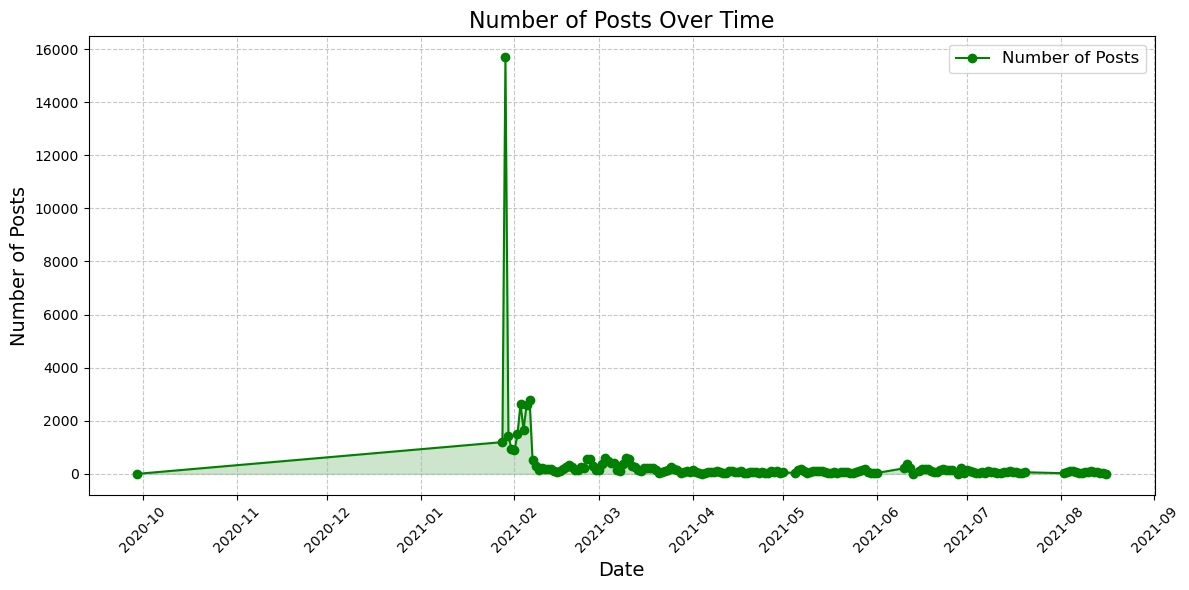

In [53]:
    # Aggregate data: count the number of posts per date
    post_counts = combined_df.groupby('timestamp').size()

    # Plot the data with date on the x-axis
    plt.figure(figsize=(12, 6))
    plt.plot(post_counts.index, post_counts.values, marker='o', linestyle='-', color='green', label='Number of Posts')
    plt.fill_between(post_counts.index, post_counts.values, color='green', alpha=0.2)  # Optional area shading

    # Format the plot
    plt.title('Number of Posts Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Number of Posts', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()



This plot highlights a single post dated before 2021-21, which will be removed to create a more streamlined dataset. The plot also shows that the highsest concentration of post is around 202102 so going forward the data will be limited to the first two weeks (2021-01-28 to 2021-02-10) in order to condense the dataset for further analysis.

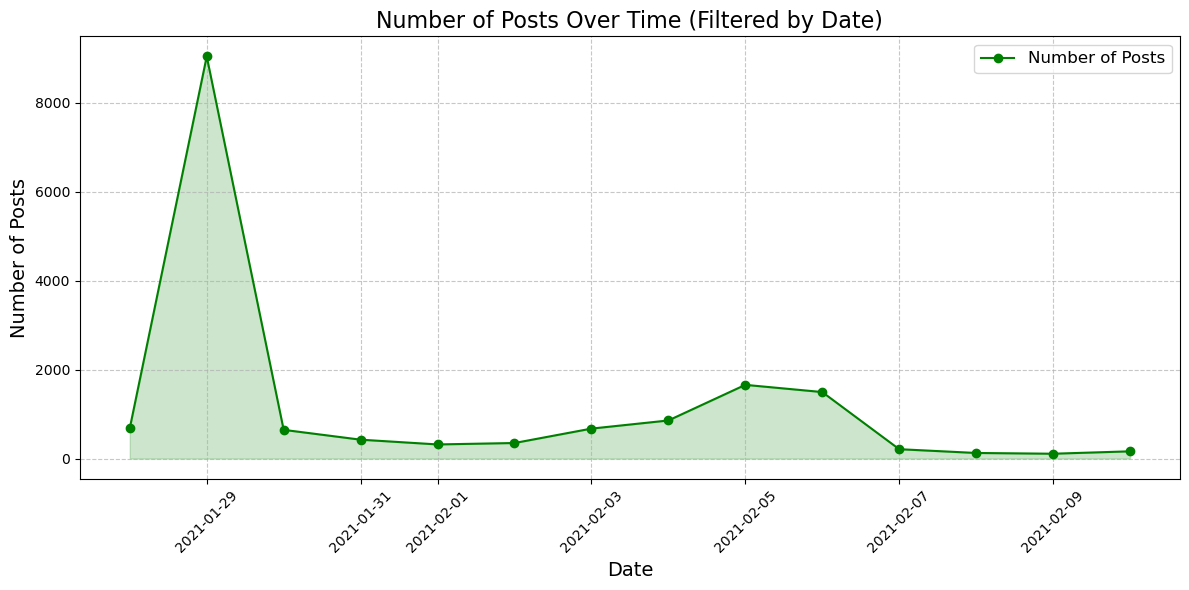

Filtered data has been saved in a list of dictionaries.
Number of records: 16775


In [63]:
# Check if required columns exist
if 'timestamp' in combined_df.columns and 'body' in combined_df.columns:
    # Reuse cleaned data: ensure 'full_text' column exists
    if 'full_text' not in combined_df.columns:
        combined_df = combined_df[['timestamp', 'body']].fillna('')
        combined_df['full_text'] = combined_df['body'].str[:50]  # Use truncated 'body' for full_text
        combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp']).dt.date
        combined_df = combined_df[combined_df['body'] != '']  # Remove rows with empty 'body'

    # Aggregate data: count the number of posts per date
    post_counts = combined_df.groupby('timestamp').size()

    # Filter data to the specified date range
    start_date = pd.to_datetime('2021-01-28').date()
    end_date = pd.to_datetime('2021-02-10').date()
    filtered_post_counts = post_counts.loc[start_date:end_date]

    # Check if filtered data is empty
    if filtered_post_counts.empty:
        print("No posts found within the specified date range.")
    else:
        # Plot the filtered data
        plt.figure(figsize=(12, 6))
        plt.plot(filtered_post_counts.index, filtered_post_counts.values, marker='o', linestyle='-', 
                 color='green', label='Number of Posts')
        plt.fill_between(filtered_post_counts.index, filtered_post_counts.values, color='green', alpha=0.2)

        # Update the plot title to reflect the filtering
        plt.title('Number of Posts Over Time (Filtered by Date)', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Number of Posts', fontsize=14)
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12)

        # Finalize and show the plot
        plt.tight_layout()
        plt.show()

        # Save the filtered data into a list of dictionaries
        filtered_data = combined_df[(combined_df['timestamp'] >= start_date) & 
                                    (combined_df['timestamp'] <= end_date)]
        filtered_list = filtered_data[['timestamp', 'full_text']].to_dict(orient='records')

        # Confirmation message
        print("Filtered data has been saved in a list of dictionaries.")
        print(f"Number of records: {len(filtered_list)}")

else:
    print("Missing one or more required columns ('timestamp' or 'body').")


Before using the NLP tools of NER and AFINN to determine if the chat on reddit has any relation with the performance on the stock market, the data needs to be cleaned.